In [1]:
#%conda install -c conda-forge/label/cf202003 implicit

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix, coo_matrix

# Детерминированные алгоритмы
from implicit.nearest_neighbours import ItemItemRecommender, CosineRecommender, TFIDFRecommender, BM25Recommender

# Метрики
from implicit.evaluation import train_test_split
from implicit.evaluation import precision_at_k, mean_average_precision_at_k,  ndcg_at_k #AUC_at_k,

In [3]:
data = pd.read_csv('./data/retail_train.csv')
data.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [4]:
data.describe()

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
count,2.396804e+06,2.396804e+06,2.396804e+06,2.396804e+06,2.396804e+06,2.396804e+06,2.396804e+06,2.396804e+06,2.396804e+06,2.396804e+06,2.396804e+06,2.396804e+06
mean,1.271904e+03,3.336643e+10,3.639770e+02,2.827247e+06,1.003763e+02,3.100821e+00,3.048227e+03,-5.400708e-01,1.561714e+03,5.268156e+01,-1.638696e-02,-2.897905e-03
std,7.265644e+02,4.284798e+09,1.759385e+02,3.732798e+06,1.152379e+03,4.210229e+00,8.785542e+03,1.245824e+00,4.015691e+02,2.513310e+01,2.168615e-01,3.974618e-02
min,1.000000e+00,2.698485e+10,1.000000e+00,2.567100e+04,0.000000e+00,0.000000e+00,1.000000e+00,-1.300200e+02,0.000000e+00,1.000000e+00,-5.593000e+01,-7.700000e+00
25%,6.550000e+02,3.008714e+10,2.160000e+02,9.169930e+05,1.000000e+00,1.290000e+00,3.300000e+02,-6.900000e-01,1.307000e+03,3.200000e+01,0.000000e+00,0.000000e+00
50%,1.271000e+03,3.241998e+10,3.660000e+02,1.027569e+06,1.000000e+00,2.000000e+00,3.700000e+02,-2.000000e-02,1.614000e+03,5.300000e+01,0.000000e+00,0.000000e+00
75%,1.914000e+03,3.514580e+10,5.150000e+02,1.132178e+06,1.000000e+00,3.490000e+00,4.220000e+02,0.000000e+00,1.844000e+03,7.400000e+01,0.000000e+00,0.000000e+00
max,2.500000e+03,4.165679e+10,6.630000e+02,1.802456e+07,8.963800e+04,8.400000e+02,3.428000e+04,3.990000e+00,2.359000e+03,9.500000e+01,0.000000e+00,0.000000e+00


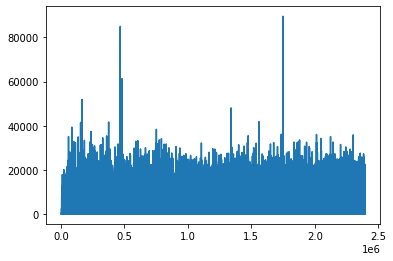

In [5]:
plt.plot(data['quantity'])

In [6]:
test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

Создадим датафрейм с покупками юзеров на тестовом датасете (последние 3 недели)

In [7]:
result = pd.read_csv('./data/predictions_basic.csv')
result.head(5)

,user_id,actual,random_recommendation,popular_recommendation,itemitem,cosine,tfidf,own_purchases
0,1,[ 821867 834484 856942 865456 889248 ...,"[5570118, 888350, 1008814, 1133254, 7168874]","[6534178, 6533889, 1029743, 6534166, 1082185]","[999999, 1082185, 981760, 1127831, 995242]","[1082185, 999999, 981760, 1127831, 1098066]","[1082185, 981760, 1127831, 999999, 1098066]","[999999, 1082185, 1029743, 995785, 1004906]"
1,3,[ 835476 851057 872021 878302 879948 ...,"[886370, 972515, 996333, 5592324, 8157350]","[6534178, 6533889, 1029743, 6534166, 1082185]","[999999, 1082185, 981760, 1098066, 995242]","[1082185, 1098066, 981760, 999999, 826249]","[1082185, 981760, 1098066, 826249, 999999]","[999999, 1082185, 1098066, 6534178, 1127831]"
2,6,[ 920308 926804 946489 1006718 1017061 ...,"[1080521, 1792866, 7467041, 861904, 17330511]","[6534178, 6533889, 1029743, 6534166, 1082185]","[999999, 1082185, 981760, 1127831, 995242]","[1082185, 999999, 981760, 1127831, 1098066]","[1082185, 981760, 1127831, 999999, 878996]","[999999, 1082185, 1029743, 6534178, 1127831]"
3,7,[ 840386 889774 898068 909714 929067 ...,"[1756761, 929999, 103481, 5579256, 9275956]","[6534178, 6533889, 1029743, 6534166, 1082185]","[999999, 1082185, 981760, 1127831, 995242]","[1082185, 981760, 999999, 1127831, 961554]","[1082185, 981760, 1127831, 999999, 961554]","[999999, 1082185, 1029743, 1127831, 995785]"
4,8,[ 835098 872137 910439 924610 992977 ...,"[1105436, 933681, 1085563, 1301966, 877811]","[6534178, 6533889, 1029743, 6534166, 1082185]","[999999, 1082185, 981760, 1127831, 1098066]","[1082185, 981760, 999999, 1098066, 826249]","[1082185, 981760, 999999, 1098066, 826249]","[999999, 1082185, 1029743, 1098066, 6534178]"


### Задание 1. Weighted Random Recommendation

Напишите код для случайных рекоммендаций, в которых вероятность рекомендовать товар прямо пропорциональна логарифму продаж
- Можно сэмплировать товары случайно, но пропорционально какому-либо весу
- Например, прямопропорционально популярности. Вес = log(sales_sum товара)

In [8]:
grouped = data_train.groupby('item_id')['quantity'].sum().reset_index()
grouped['weights'] = grouped['quantity']/ np.sum(grouped['quantity'])
grouped.sort_values('weights', ascending=False, inplace=True)
grouped.head()

,item_id,quantity,weights
55470,6534178,190227964,0.829765
55430,6533889,15978434,0.069697
55465,6534166,12439291,0.054260
55576,6544236,2501949,0.010913
43620,1404121,1562004,0.006813


In [9]:
recs = np.random.choice(grouped['item_id'], size=5, replace=False, p = grouped['weights'])
recs

array([6534178, 5703832, 6534166, 6533889,  636668])

In [10]:
def weighted_random_recommendation(items_weights, n=5):
    """Случайные рекоммендации
    Input
    -----
    items_weights: pd.DataFrame
        Датафрейм со столбцами item_id, weight. Сумма weight по всем товарам = 1
    """
    
    recs = np.random.choice(grouped['item_id'], size=n, replace=False, p = grouped['weights'])
    return recs.tolist()

Сделайте предсказания

In [11]:
%%time

# your_code
result['weighted_random_recommendation'] = result['user_id'].apply(lambda x: weighted_random_recommendation(grouped, n=5))
result.head(2)

CPU times: user 4.43 s, sys: 12.6 ms, total: 4.44 s
Wall time: 4.44 s


,user_id,actual,random_recommendation,popular_recommendation,itemitem,cosine,tfidf,own_purchases,weighted_random_recommendation
0,1,[ 821867 834484 856942 865456 889248 ...,"[5570118, 888350, 1008814, 1133254, 7168874]","[6534178, 6533889, 1029743, 6534166, 1082185]","[999999, 1082185, 981760, 1127831, 995242]","[1082185, 999999, 981760, 1127831, 1098066]","[1082185, 981760, 1127831, 999999, 1098066]","[999999, 1082185, 1029743, 995785, 1004906]","[6534178, 6534166, 6533889, 13213194, 981776]"
1,3,[ 835476 851057 872021 878302 879948 ...,"[886370, 972515, 996333, 5592324, 8157350]","[6534178, 6533889, 1029743, 6534166, 1082185]","[999999, 1082185, 981760, 1098066, 995242]","[1082185, 1098066, 981760, 999999, 826249]","[1082185, 981760, 1098066, 826249, 999999]","[999999, 1082185, 1098066, 6534178, 1127831]","[6534178, 6534166, 6533889, 480014, 1404121]"


### Задание 2. Расчет метрик
Рассчитайте Precision@5 для каждого алгоритма с помощью функции из вебинара 1. Какой алгоритм показывает лучшее качество?

In [24]:
#%conda install src

In [25]:
from src.metrics import precision_at_k, recall_at_k

ModuleNotFoundError: No module named 'src'

In [20]:
result.apply(lambda row: precision_at_k(row['random_recommendation'], row['actual']), axis=1).mean()

TypeError: precision_at_k() takes at least 3 positional arguments (2 given)

In [ ]:
result.apply(lambda row: precision_at_k(row['popular_recommendation'], row['actual']), axis=1).mean()

### Задание 3*. Улучшение бейзлайнов и ItemItem

- Попробуйте улучшить бейзлайны, считая их на топ-5000 товаров
- Попробуйте улучшить разные варианты ItemItemRecommender, выбирая число соседей $K$.
- Попробуйте стратегии ансамблирования изученных алгоритмов

In [ ]:
# your_code